# FuncVeil: 미적분 기반 개인정보 마스킹 시스템 데모

이 노트북은 미적분 개념을 활용한 비가역적 개인정보 마스킹 알고리즘을 소개합니다. 고등학교 교육과정에서 배우는 미적분 지식을 활용하여 개인정보를 보호하면서도 통계적 분석이 가능한 데이터로 변환하는 방법을 시연합니다.

In [2]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# 패키지 경로 추가 - src 디렉토리를 경로에 추가
sys.path.insert(0, os.path.abspath('../src'))

# FuncVeil 라이브러리 임포트
from funcveil.masking.sin import SinMask
from funcveil.masking.logexp import LogExpMask
from funcveil.masking.composite import CompositeMask
from funcveil.masking.hmac_mask import HMACMask
from funcveil.evaluation.reversibility import calculate_invertibility_score, visualize_mask_function
from funcveil.evaluation.dp_sensitivity import evaluate_dp_sensitivity, compare_dp_impact
from funcveil.evaluation.benchmarks import compare_masking_methods, generate_benchmark_summary
from funcveil.utils import set_seed

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 난수 시드 설정 (재현성)
set_seed(42)

## 1. 샘플 데이터 import

먼저 마스킹 알고리즘을 시연하기 위한 샘플 데이터를 생성한 데이터를 가져옵니다.

In [3]:
# 데이터 형태
# data = {
#     'ID': list(range(1, n_samples + 1)),
#     '이름': [f'사용자{i}' for i in range(1, n_samples + 1)],
#     '나이': np.random.randint(25, 45, n_samples),
#     '연봉': np.random.normal(4000000, 1000000, n_samples).astype(int),
#     '주민번호': [f'{900101+i:06d}-{np.random.randint(1000000, 9999999):07d}' for i in range(n_samples)],
#     '생년월일': [f'{1979+i//10:4d}-{(i%12)+1:02d}-{np.random.randint(1, 29):02d}' for i in range(n_samples)]
# }

# 데이터프레임 import
df = pd.read_csv('personal_data.csv')
df.head()

,ID,이름,나이,연봉,주민번호,생년월일
0,1,김민준,28,42000000,950101-1234567,1995-01-01
1,2,이서연,32,58000000,910215-2345678,1991-02-15
2,3,박지훈,35,65000000,880630-3456789,1988-06-30
3,4,최수아,27,38000000,960715-4567890,1996-07-15
4,5,정도윤,41,85000000,820325-5678901,1982-03-25


## 2. 기본 연속 함수 기반 마스킹 (sin 함수)

먼저 가장 기본적인 마스킹 방법인 사인 함수를 사용한 마스킹을 구현해 보겠습니다. 기본 수식은 다음과 같습니다:

$$f(x) = A \cdot \sin(\omega \cdot \frac{x - L}{U - L} + \phi) + B$$

여기서:
- $x \in [L, U]$: 정규화된 입력값 범위
- $A, \omega, \phi, B$: 시드 기반으로 생성되는 파라미터

원본 데이터 vs 마스킹 데이터:
   나이  나이_마스킹
0  28    5.66
1  32    5.53
2  35    5.41
3  27    5.69
4  41    5.09


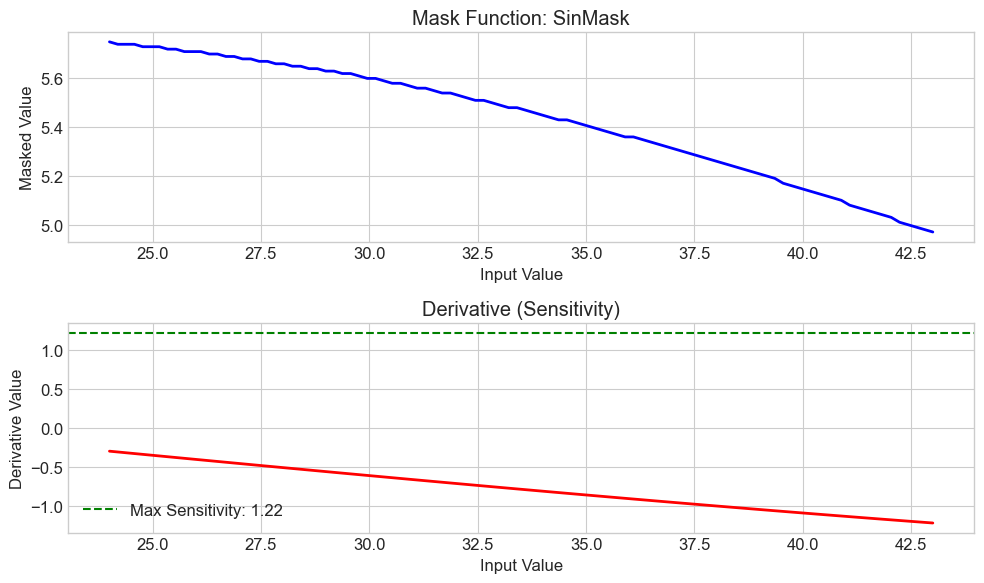

In [4]:
# '나이' 필드에 대해 사인 함수 마스킹 적용하기
# 1. 마스킹 객체 생성
age_mask = SinMask(seed=42)

# 2. 데이터 범위에 맞게 초기화
age_mask.fit(df['나이'].values)

# 3. 마스킹 적용
df['나이_마스킹'] = df['나이'].apply(lambda x: age_mask(x))

# 4. 결과 확인
print("원본 데이터 vs 마스킹 데이터:")
print(df[['나이', '나이_마스킹']].head())

# 5. 마스킹 함수 시각화
visualize_mask_function(age_mask)

### 마스킹 함수의 역변환 가능성 평가

동일한 마스킹 결과값에 여러 입력값이 대응되는 경우, 마스킹의 비가역성이 높아집니다. 이를 정량적으로 평가해 보겠습니다.

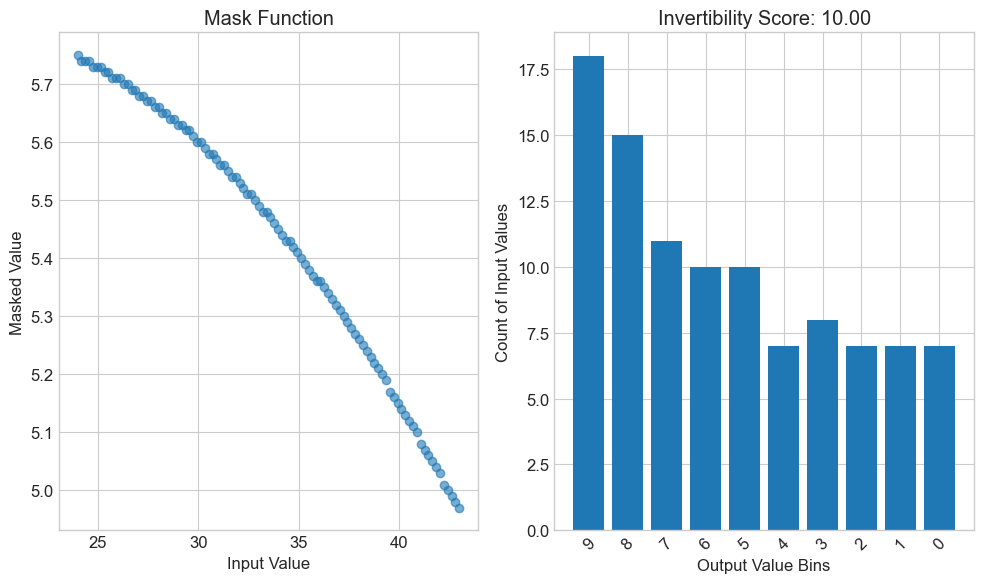

역변환 가능성 점수: 10.00 (1.0은 일대일 대응, 값이 클수록 역변환 어려움)


In [5]:
# 역변환 가능성 점수 계산 (값이 클수록 역변환 어려움)
inv_score = calculate_invertibility_score(age_mask, plot=True)
print(f"역변환 가능성 점수: {inv_score:.2f} (1.0은 일대일 대응, 값이 클수록 역변환 어려움)")

## 3. 단조성 제한 옵션 적용

단조 구간을 제한하여 역함수가 존재하도록 만들 수 있습니다. 이는 교육적 목적으로 활용할 수 있으며, `-invertible` CLI 옵션으로 활성화할 수 있습니다.

$$\omega (U - L) \leq \pi$$

위 조건을 적용하면 마스킹 함수가 단조 증가하게 됩니다.

원본 데이터 vs 마스킹 데이터 vs 단조 마스킹:
   나이  나이_마스킹  나이_단조마스킹
0  28    5.66      5.72
1  32    5.53      5.70
2  35    5.41      5.68
3  27    5.69      5.73
4  41    5.09      5.63


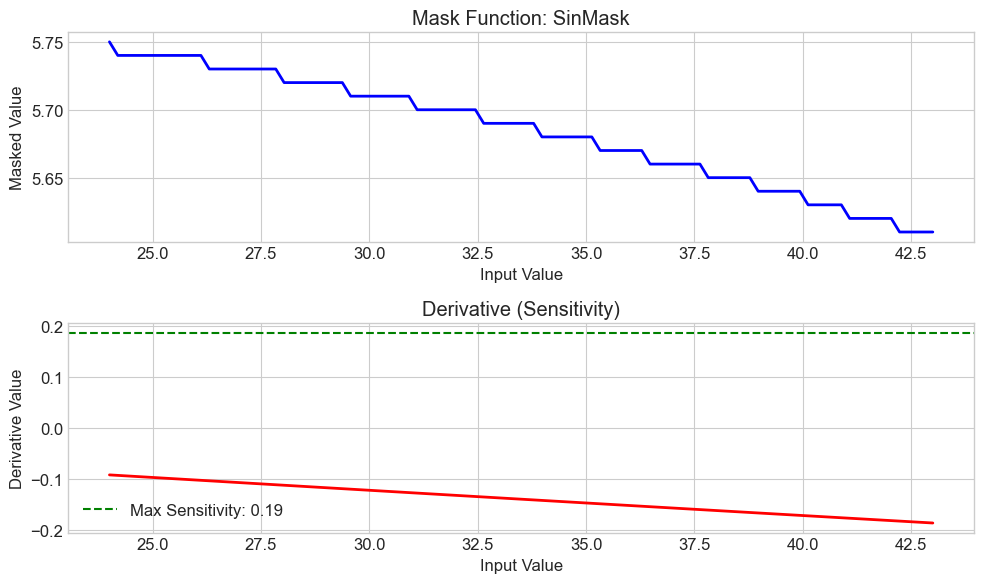

In [6]:
# 단조 제한 옵션 적용한 마스킹
monotonic_mask = SinMask(seed=42, monotonic=True)
monotonic_mask.fit(df['나이'].values)

# 마스킹 적용
df['나이_단조마스킹'] = df['나이'].apply(lambda x: monotonic_mask(x))

# 결과 비교
print("원본 데이터 vs 마스킹 데이터 vs 단조 마스킹:")
print(df[['나이', '나이_마스킹', '나이_단조마스킹']].head())

# 마스킹 함수 시각화
visualize_mask_function(monotonic_mask)

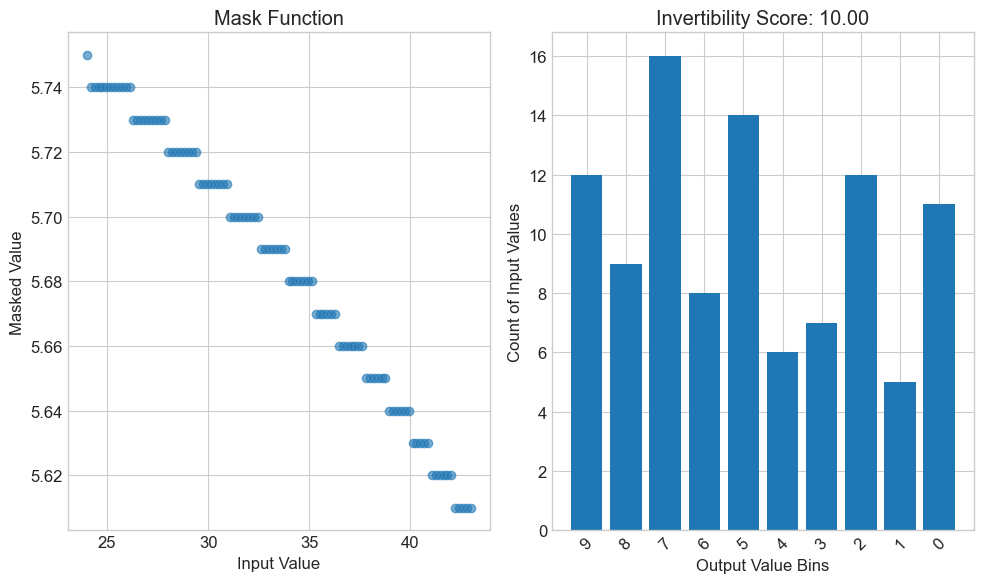

단조 마스킹 역변환 가능성 점수: 10.00
일반 마스킹 역변환 가능성 점수: 10.00
단조 제한 옵션 적용 시 역변환 가능성이 1.00배 증가


In [7]:
# 역변환 가능성 점수 비교
mono_inv_score = calculate_invertibility_score(monotonic_mask, plot=True)
print(f"단조 마스킹 역변환 가능성 점수: {mono_inv_score:.2f}")
print(f"일반 마스킹 역변환 가능성 점수: {inv_score:.2f}")
print(f"단조 제한 옵션 적용 시 역변환 가능성이 {mono_inv_score/inv_score:.2f}배 증가")

## 4. 다양한 마스킹 함수 적용

이제 다른 마스킹 함수들을 적용해 보겠습니다. 지수/로그 함수, 복합 함수, HMAC 결합 마스킹을 차례로 적용하고 결과를 비교해 봅시다.

In [8]:
# 다양한 마스킹 함수들

# 1. 지수 함수 마스킹
exp_mask = LogExpMask(seed=42, use_log=False)
exp_mask.fit(df['나이'].values)
df['나이_지수마스킹'] = df['나이'].apply(lambda x: exp_mask(x))

# 2. 로그 함수 마스킹
log_mask = LogExpMask(seed=42, use_log=True)
log_mask.fit(df['나이'].values)
df['나이_로그마스킹'] = df['나이'].apply(lambda x: log_mask(x))

In [9]:
# 3. 복합 함수 마스킹 (sin + cos)
composite_mask = CompositeMask(seed=42)
composite_mask.fit(df['나이'].values)
df['나이_복합마스킹'] = df['나이'].apply(lambda x: composite_mask(x))

# 4. HMAC 결합 마스킹
hmac_mask = HMACMask(seed=42, hmac_key="secret_key_123")
hmac_mask.fit(df['나이'].values)
df['나이_HMAC마스킹'] = df['나이'].apply(lambda x: hmac_mask(x))

# 결과 비교
print("다양한 마스킹 함수 결과 비교:")
mask_cols = ['나이', '나이_마스킹', '나이_지수마스킹', '나이_로그마스킹', '나이_복합마스킹', '나이_HMAC마스킹']
print(df[mask_cols].head())

다양한 마스킹 함수 결과 비교:
   나이  나이_마스킹  나이_지수마스킹  나이_로그마스킹  나이_복합마스킹     나이_HMAC마스킹
0  28    5.66      3.02      5.95     12.91  3bc67bc2:5.66
1  32    5.53      3.09      6.09     13.03  b43f72d8:5.53
2  35    5.41      3.14      6.19     12.83  f2d8db3c:5.41
3  27    5.69      3.01      5.91     12.82  3cdec4f6:5.69
4  41    5.09      3.25      6.38     11.72  7cfdcfa6:5.09


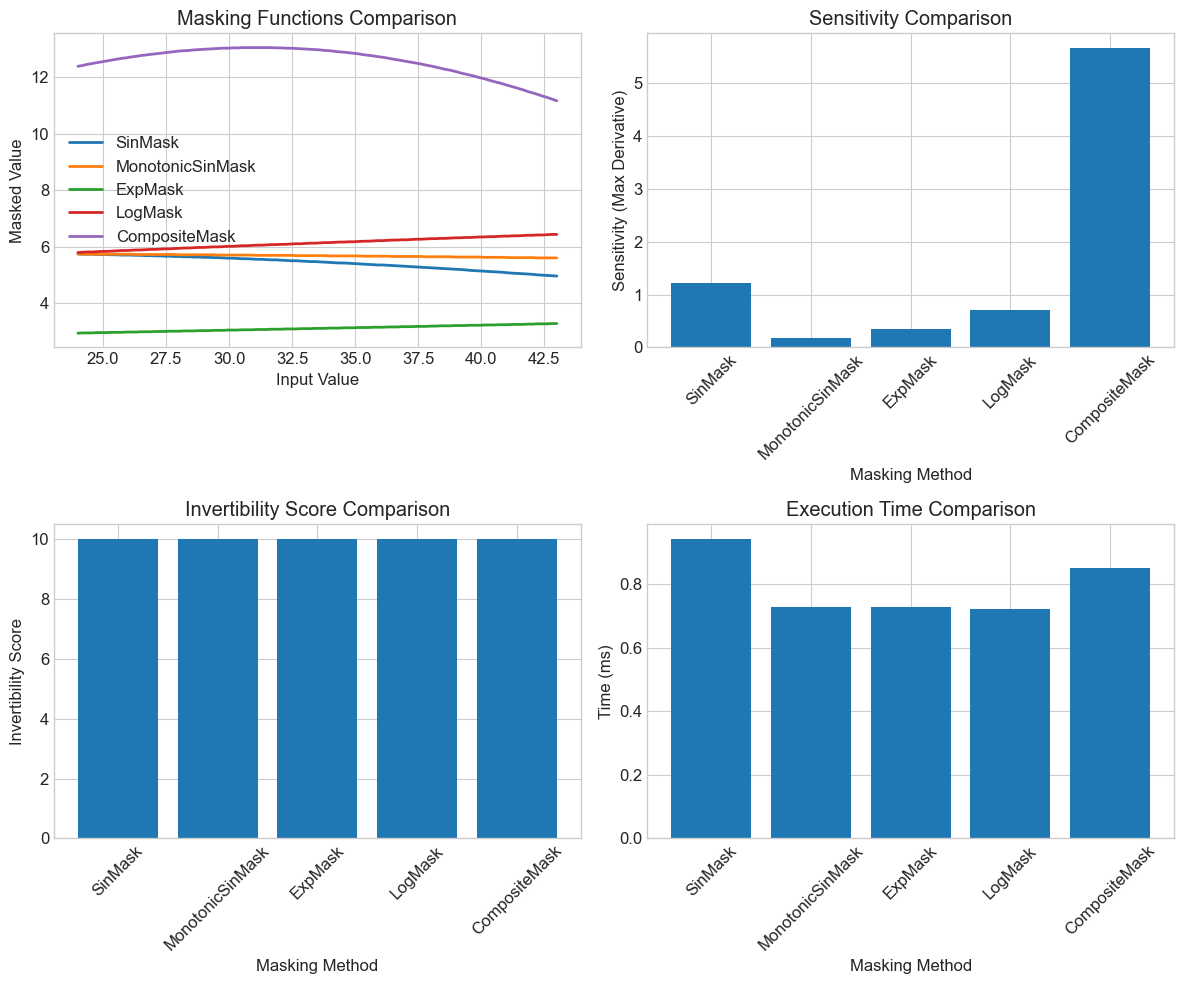

,Method,Sensitivity,Invertibility Score,Output Range,Execution Time (ms),Output Mean,Output Std
0,SinMask,1.224302,10.0,4.97 - 5.75,0.941038,5.4323,0.231036
1,MonotonicSinMask,0.186503,10.0,5.61 - 5.75,0.729084,5.6839,0.040790
2,ExpMask,0.353671,10.0,2.95 - 3.29,0.727654,3.1194,0.097743
3,LogMask,0.700983,10.0,5.80 - 6.44,0.721931,6.1320,0.186279
4,CompositeMask,5.666319,10.0,11.16 - 13.04,0.852108,12.5495,0.511946


In [10]:
# 다양한 마스킹 함수 시각화 및 비교
masks = {
    'SinMask': age_mask,
    'MonotonicSinMask': monotonic_mask,
    'ExpMask': exp_mask,
    'LogMask': log_mask,
    'CompositeMask': composite_mask
}

# 데이터 범위
data_range = (df['나이'].min(), df['나이'].max())

# 마스킹 함수 비교
benchmark_results = compare_masking_methods(masks, data_range)

# 요약 표 생성
summary_df = generate_benchmark_summary(benchmark_results)
summary_df

## 5. 차분 프라이버시(DP) 노이즈 결합

마스킹 함수에 차분 프라이버시 노이즈를 추가하여 더 강력한 개인정보 보호 기능을 구현할 수 있습니다. 이 과정에서 도함수(민감도)가 중요한 역할을 합니다.

$$f(x) = round(f(x) + L(b), n), b = \frac{\Delta f}{\epsilon}$$

여기서:
- $L(b)$: 라플라스 노이즈
- $\Delta f = \max |f'(x)|$: 도함수 기반 민감도
- $\epsilon$: 프라이버시 파라미터 (작을수록 보호 강화, 노이즈 증가)

In [11]:
# DP 적용을 위한 마스킹 함수
dp_mask = SinMask(seed=42, dp_epsilon=1.0)  # ε = 1.0
dp_mask.fit(df['나이'].values)

# DP 적용 마스킹 수행 (여러 번 실행 시 다른 결과)
df['나이_DP마스킹_1'] = df['나이'].apply(lambda x: dp_mask(x))
df['나이_DP마스킹_2'] = df['나이'].apply(lambda x: dp_mask(x))

# 결과 비교
print("차분 프라이버시 적용 결과 (동일 입력에 대해 다른 결과):")
print(df[['나이', '나이_마스킹', '나이_DP마스킹_1', '나이_DP마스킹_2']].head())

차분 프라이버시 적용 결과 (동일 입력에 대해 다른 결과):
   나이  나이_마스킹 나이_DP마스킹_1 나이_DP마스킹_2
0  28    5.66     [5.31]     [2.27]
1  32    5.53     [8.37]     [5.92]
2  35    5.41     [6.17]     [4.84]
3  27    5.69     [5.96]     [5.71]
4  41    5.09     [3.66]     [7.16]


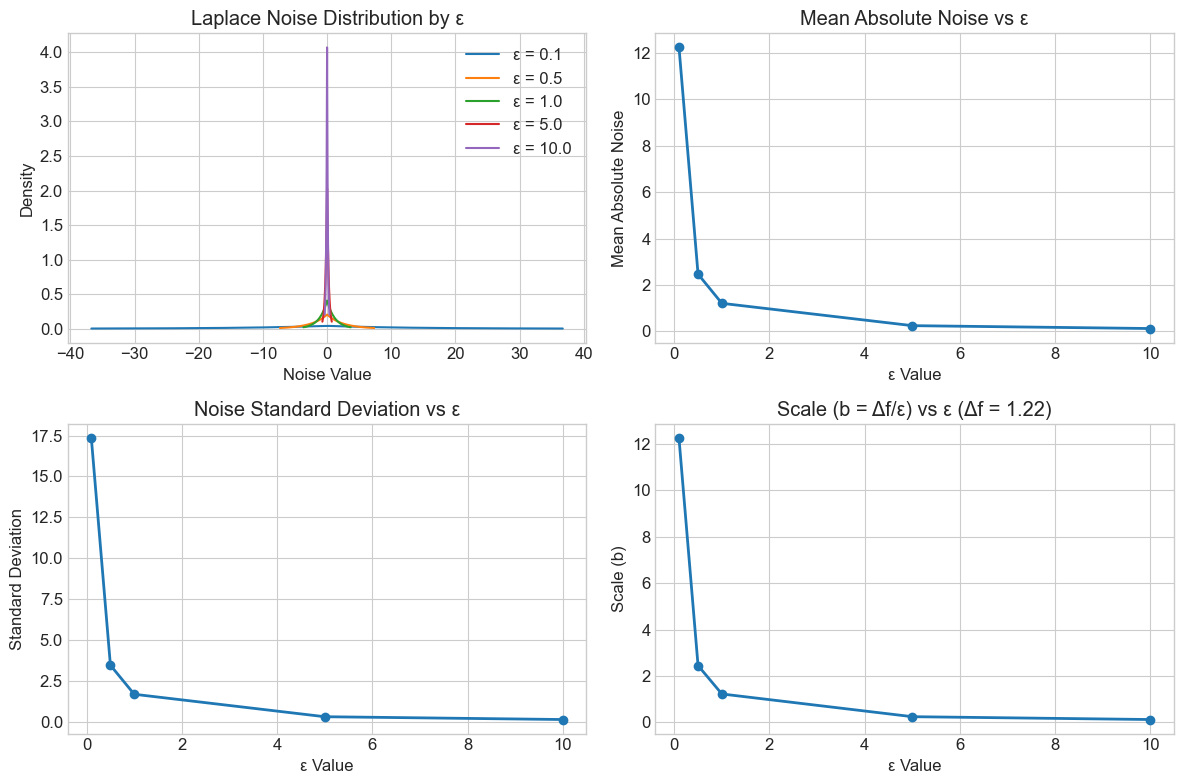

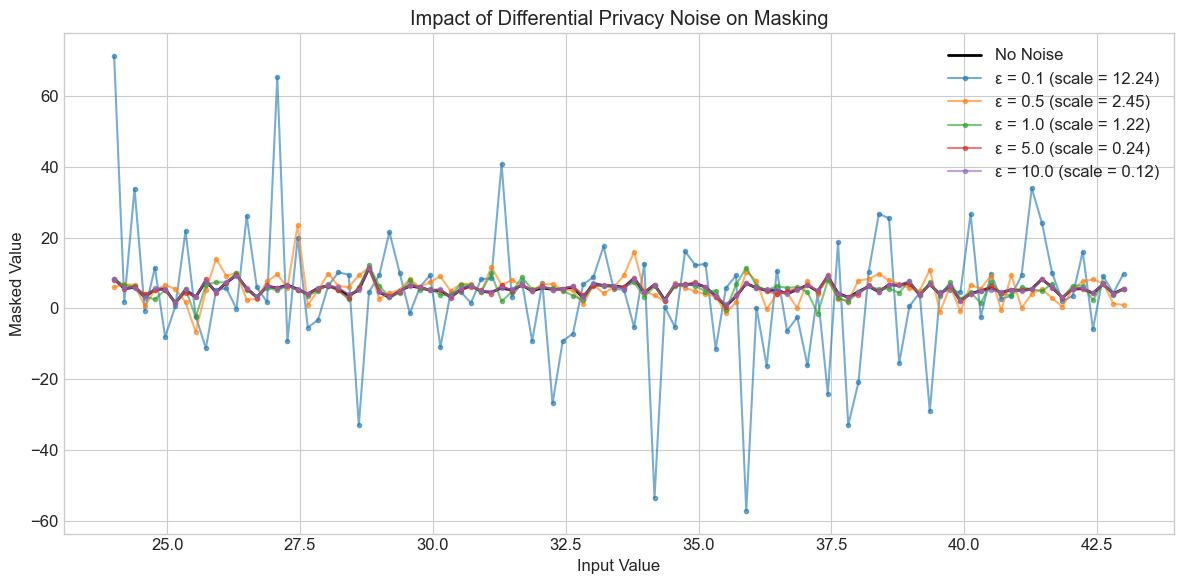

In [12]:
# 다양한 엡실론 값에 따른 DP 효과 비교
epsilon_values = [0.1, 0.5, 1.0, 5.0, 10.0]

# DP 민감도 평가
dp_stats = evaluate_dp_sensitivity(dp_mask, epsilon_values=epsilon_values)

# DP 적용 효과 시각화
compare_dp_impact(dp_mask, epsilon_values=epsilon_values)

## 6. 다른 필드에 대한 마스킹 적용

이제 다른 필드('연봉')에 대해서도 마스킹을 적용해 보겠습니다.

연봉 마스킹 결과:
         연봉  연봉_마스킹
0  42000000  [2.82]
1  58000000  [4.76]
2  65000000   [3.6]
3  38000000  [3.16]
4  85000000  [2.47]


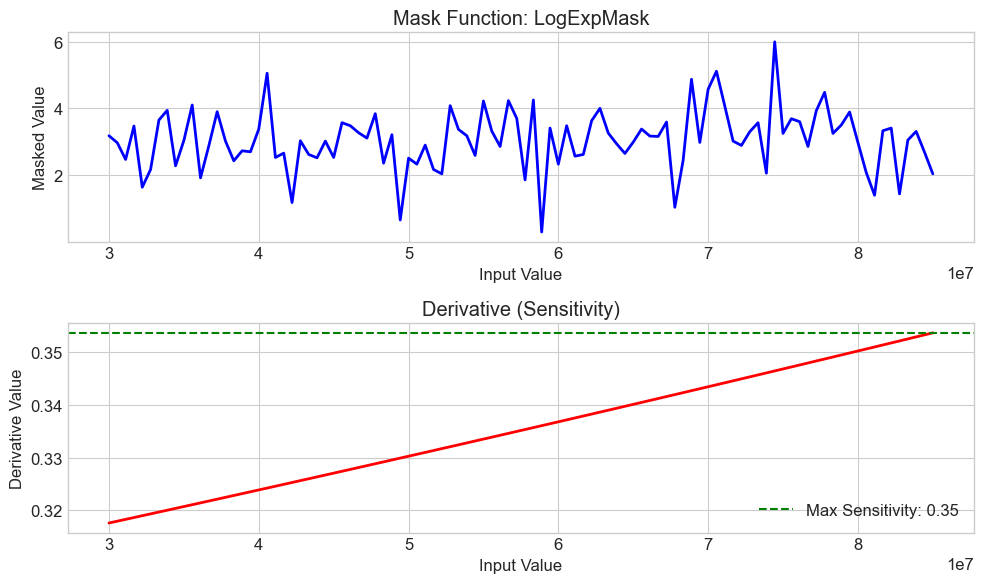

In [13]:
# 연봉 필드에 대한 마스킹
salary_mask = LogExpMask(seed=42, dp_epsilon=0.5)  # 로그 기반 마스킹 + DP
salary_mask.fit(df['연봉'].values)
df['연봉_마스킹'] = df['연봉'].apply(lambda x: salary_mask(x))

# 결과 확인
print("연봉 마스킹 결과:")
print(df[['연봉', '연봉_마스킹']].head())

# 마스킹 함수 시각화
visualize_mask_function(salary_mask)

## 7. 전체 데이터 마스킹 및 저장

이제 전체 데이터프레임의 민감한 필드에 적절한 마스킹을 모두 적용해 보겠습니다.

In [14]:
# 주민번호 마스킹 (HMAC 활용)
id_mask = HMACMask(seed=42, hmac_key="highly_secure_key")
# 주민번호는 숫자가 아닌 문자열이지만, ID 값으로 피팅
id_mask.fit(df['ID'].values)
df['주민번호_마스킹'] = df['주민번호'].apply(lambda x: id_mask(hash(x)))

# 생년월일 마스킹 (복합 함수 + DP)
date_mask = CompositeMask(seed=42, dp_epsilon=1.0)
date_mask.fit(df['ID'].values)  # ID로 피팅
df['생년월일_마스킹'] = df['생년월일'].apply(lambda x: f"DATE-{date_mask(hash(x))}")

# 최종 마스킹된 데이터프레임 생성
masked_df = df[['ID', '이름', '나이_마스킹', '연봉_마스킹', '주민번호_마스킹', '생년월일_마스킹']]
masked_df.columns = ['ID', '이름', '나이', '연봉', '주민번호', '생년월일']  # 원래 열 이름으로 변경

# 결과 확인
print("최종 마스킹된 데이터:")
masked_df.head()

최종 마스킹된 데이터:


,ID,이름,나이,연봉,주민번호,생년월일
0,1,김민준,5.66,[2.82],4284aaf4:1.65,DATE-[1.44]
1,2,이서연,5.53,[4.76],fa4b3210:5.71,DATE-[18.48]
2,3,박지훈,5.41,[3.6],c07bb5e5:3.79,DATE-[4.22]
3,4,최수아,5.69,[3.16],ae5d14a8:3.88,DATE-[6.45]
4,5,정도윤,5.09,[2.47],25919cc2:4.74,DATE-[-5.82]


In [15]:
#결과 저장 (선택적)
masked_df.to_csv('masked_personal_data.csv', index=False)
print("마스킹된 데이터를 'masked_personal_data.csv'로 저장했습니다.")

마스킹된 데이터를 'masked_personal_data.csv'로 저장했습니다.


## 8. 결론 및 교육적 활용 방안

지금까지 미적분 개념을 활용한 다양한 마스킹 기법을 살펴보았습니다. 이 프로젝트는 수학적 개념을 실생활 문제(개인정보 보호)에 적용하는 방법을 보여주는 좋은 예시입니다.

### 교육적 활용 방안

1. **연속함수**: 입력 데이터를 마스킹하는 함수를 정의하고 특성 탐구
2. **도함수**: 함수의 민감도를 계산하고 차분 프라이버시에 활용
3. **합성함수**: 여러 함수를 조합한 복합 마스킹 함수 설계
4. **역함수**: 단조성을 제한하여 역함수 존재 여부 제어
5. **통계 및 데이터 과학**: 마스킹된 데이터에 대한 통계적 특성 분석

이 노트북을 통해 학생들은 고등학교 교육과정에서 배우는 미적분 개념이 실제 프라이버시 보호 및 데이터 과학 분야에서 어떻게 활용될 수 있는지 체험할 수 있습니다.